# Blood pressure prediction

### Project discription 

The challenge is to evaluate systolic (SBP) and diastolic (DBP) blood pressure for a specific person using a photoplethysmogram (PPG) and an electrocardiogram (ECG)

ECG - Electrocardiography (ECG or EKG) is the process of recording the electrical activity of the heart over a period of time using electrodes placed over the skin. 

PPG - A photoplethysmogram (PPG) is an optically obtained plethysmogram, a volumetric measurement of an organ. A PPG is often obtained by using a pulse oximeter which illuminates the skin and measures changes in light absorption.

Blood Pressure is the pressure of circulating blood on the walls of blood vessels. Blood pressure is usually expressed in terms of the Systolic Blood Pressure (maximum during one heart beat) over Diastolic Blood Pressure (minimum in between two heart beats) and is measured in millimeters of mercury.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, math
from scipy.fftpack import fft, ifft
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression, Ridge
import glob,scipy
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy import signal, stats
from scipy.signal import butter,lfilter
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost

C:\Users\maxel\Anaconda33\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Functions' initialization

In [2]:
Lim_min = 1000 #limits for uploading data
Lim_max = 13500
CONSTANT = 13701 #length of array
MAX_VALUE = 10000

In [3]:
#Forward and inverse fourier transform to chech signal after transformation
def magic_fft(data):
    "Forward and inverse fourier transform"
    spec = fft(data)
            
    strt = 0
    stp = 10
    spec[strt:stp],spec[len(spec)-stp:len(spec)-strt] = np.zeros(stp - strt),np.zeros(stp - strt)
    
    strt = CONSTANT//2 - 6400
    stp = CONSTANT//2
    
    spec[strt:stp],spec[len(spec)-stp:len(spec)-strt] = np.zeros(stp - strt),np.zeros(stp - strt)

    return np.abs(ifft(spec) + np.mean(data))

In [4]:
def window(data,w):
    out = data
    
    for i in range(0,out.shape[0],w):
        d1,d2 = np.argmax(out[i:i+w]),np.max(out[i:i+w])
        out[i:i+w] = np.zeros_like(out[i:i+w])
        out[d1] = d2
        
        return(out)
    

In [5]:
def sorting(data,t):
    "Filtering of FFT"
    #sor = np.sort(data)[::-1]
    #sor[t::] = np.zeros_like(sor[t::]) 
    out = np.zeros_like(data)
    dummy = data
    for i in range(t):
        d1,d2 = np.argmax(dummy),np.max(dummy)
        out[d1] = d2
        dummy[d1] = 0
    return(out)
    

In [6]:
#FFT transform
def fft_simple1(data):
    "FFT transformation for PPG"
    spec = fft(data)
    
    dummy = np.abs(spec[10:200])/np.max(np.abs(spec[10:200]))
    #return(np.log(dummy) + 10)
#     dummy = sorting(dummy,20)
    return(dummy)

def fft_simple2(data):
    "FFT transformation for ECG"
    spec = fft(data)
    dummy = np.abs(spec[10:400])/np.max(np.abs(spec[10:400]))
#     dummy = sorting(dummy,20)
    return(dummy)

In [7]:
#Data uploading
def read_data(path, sz):
    "Return real data from exel files as one DataFrame"
    shapes = 2*sz + 2
    out = np.ones(shapes)
    
    for csv in glob.glob('{}/*.csv'.format(path)):
        
        tmp = pd.read_csv(csv, header=None)
        tmp1 = np.array(pd.read_csv(csv, header=None))
        
        a1 = np.concatenate((tmp1[:sz,0],tmp1[:sz,1]),axis = 0)
        a2 = tmp1[0,0:2]
        a12 = np.concatenate((a1, a2.T), axis=0)

    
        out = np.concatenate((out[0:],a12[0:shapes]), axis = 0)
     
    
    out = np.reshape(out, (out.shape[0]//shapes,shapes))
    return(out) 

def read_data_real(path):
    "Return real data from exel files as DataFrames"
    kek = []
    anses = []
    X_PPG, X_ECG = pd.DataFrame(),pd.DataFrame()
    Y_SBP, Y_DBP = pd.DataFrame(),pd.DataFrame()
    ID = pd.DataFrame()
    for csv in glob.glob('{}/*.csv'.format(path)):
        
        ID_num = int(re.findall(r'subj(\d+)',csv)[0])
        Numb = int(re.findall(r'log(\d+)',csv)[0])
        
        tmp = pd.read_csv(csv, header=None)
               
        X_PPG = X_PPG.append(pd.DataFrame(np.array(tmp.iloc[Lim_min:Lim_max,0]),index = tmp.index[Lim_min:Lim_max],columns = [Numb]).T)

        X_ECG = X_ECG.append(pd.DataFrame(np.array(tmp.iloc[Lim_min:Lim_max,1]),index = tmp.index[Lim_min:Lim_max],columns = [Numb]).T)
        ID.loc[Numb,'ID']=ID_num
        Y_SBP.loc[Numb,'SBP'] = tmp.loc[0,0]
        Y_DBP.loc[Numb,'DBP'] = tmp.loc[0,1]
        
        
    return X_PPG, X_ECG, Y_SBP, Y_DBP, ID

def read_data_filtered(path):
    "Return filtered data from exel files as DataFrames. Window and butterfort filters"
    
    kek = []
    anses = []
    X_PPG, X_ECG = pd.DataFrame(),pd.DataFrame()
    Y_SBP, Y_DBP = pd.DataFrame(),pd.DataFrame()
    ID = pd.DataFrame()
    
    # Filter requirements.
    order = 6 #default 6
    fs = 500.0       # sample rate, Hz
    cutoff = 15  # desired cutoff frequency of the filter, 10 Hz
    
    for csv in glob.glob('{}/*.csv'.format(path)):
        
        ID_num = int(re.findall(r'subj(\d+)',csv)[0])
        Numb = int(re.findall(r'log(\d+)',csv)[0])
        
        tmp = pd.read_csv(csv, header=None)
        
        sig1 = tmp.iloc[Lim_min:Lim_max,0]
        sig2 = tmp.iloc[Lim_min:Lim_max,1]
        sig1=filtr(sig1,2000)
        sig2=filtr(sig2,500)
        sig1 = butter_lowpass_filter(sig1, cutoff, fs, order)
        sig2 = butter_lowpass_filter(sig2, cutoff, fs, order)
               
        X_PPG = X_PPG.append(pd.DataFrame(np.array(sig1),columns = [Numb]).T)

        X_ECG = X_ECG.append(pd.DataFrame(np.array(sig2),columns = [Numb]).T)
        ID.loc[Numb,'ID']=ID_num
        Y_SBP.loc[Numb,'SBP'] = tmp.loc[0,0]
        Y_DBP.loc[Numb,'DBP'] = tmp.loc[0,1]
        
        
    return X_PPG, X_ECG, Y_SBP, Y_DBP, ID

def read_data_fft(path):
    "Return FFT transform of data from exel files as DataFrames. Window and butterfort filters"
    X_PPG, X_ECG = pd.DataFrame(),pd.DataFrame()
    Y_SBP, Y_DBP = pd.DataFrame(),pd.DataFrame()
    ID = pd.DataFrame()
    
    # Filter requirements.
    order = 6
    fs = 500.0       # sample rate, Hz
    cutoff = 15  # desired cutoff frequency of the filter, Hz
    
    for csv in glob.glob('{}/*.csv'.format(path)):
        
        tmp = pd.read_csv(csv, header=None)
        

        STD=10000
        ii=1
        for i in range(1,7001,500):
            
            if np.std(tmp.iloc[i:i+6000,1])<STD:
                STD = np.std(tmp.iloc[i:i+6000,1])
                ii=i
            
        if (np.max(tmp.iloc[ii:ii+6000,1])<3000) | (np.min(tmp.iloc[ii:ii+6000,1])>1000):
            if np.std(tmp.iloc[ii:ii+6000,1])>=60:
        
                ID_num = int(re.findall(r'subj(\d+)',csv)[0])
                Numb = int(re.findall(r'log(\d+)',csv)[0])

                sig1=tmp.iloc[ii:6000+ii,0]
                sig2=tmp.iloc[ii:6000+ii,1]

                sig1=filtr(sig1,2000)
                sig2=filtr(sig2,500)
                
                sig2 = butter_lowpass_filter(sig2, cutoff, fs, order)
                

                fft1 = fft_simple1(sig1)
                fft2 = fft_simple2(sig2)



                X_PPG = X_PPG.append(pd.DataFrame(fft1,columns = [Numb]).T)

                X_ECG = X_ECG.append(pd.DataFrame(fft2,columns = [Numb]).T)
                ID.loc[Numb,'ID']=ID_num
                Y_SBP.loc[Numb,'SBP'] = tmp.loc[0,0]
                Y_DBP.loc[Numb,'DBP'] = tmp.loc[0,1]
        
        
    return X_PPG, X_ECG, Y_SBP, Y_DBP, ID


In [8]:
def read_data_feat(path):
    "Return features of data from exel files as DataFrame"
    kek = []
    anses = []
    X_PPG, X_ECG = pd.DataFrame(),pd.DataFrame()
    Y_SBP, Y_DBP = pd.DataFrame(),pd.DataFrame()
    ID,Y_class = pd.DataFrame(),pd.DataFrame()
    Features = pd.DataFrame()
    # Filter requirements.
    order = 6 #default 6
    fs = 500.0       # sample rate, Hz
    cutoff = 15  # desired cutoff frequency of the filter, 15 Hz
    
    for csv in glob.glob('{}/*.csv'.format(path)):
        STD=10000
        ii=1
        Length = 6000
        
        tmp = pd.read_csv(csv, header=None)
        
        for i in range(1,7001,500):
            
            if np.std(tmp.iloc[i:i+Length,1])<STD:
                STD = np.std(tmp.iloc[i:i+Length,1])
                ii=i
            
        if (np.max(tmp.iloc[ii:ii+Length,1])<3000) & (np.min(tmp.iloc[ii:ii+Length,1])>1000):
            if np.std(tmp.iloc[ii:ii+Length,1])>=60:
        
                ID_num = int(re.findall(r'subj(\d+)',csv)[0])
                Numb = int(re.findall(r'log(\d+)',csv)[0])

                
                sig1 = tmp.iloc[ii:ii+Length,0]
                sig1_flt = filtr(sig1,1000)
                sig1_flt2 = butter_lowpass_filter(sig1_flt, cutoff, fs, order)
                
                sig2 = tmp.iloc[ii:ii+Length,1]
                sig2_flt = filtr(sig2,1000)
                sig2_flt2 = butter_lowpass_filter(sig2_flt, cutoff, fs, order)
                
                sig1_cut = graph_cut(sig1_flt2)
                sig2_cut = graph_cut(sig2_flt2)
                
                PWTT_temp = PWTT(sig1_flt2,sig2_flt2)
                if (PWTT_temp != 0) & (not(np.isnan(PWTT_temp))):
                    if (sig1_cut.shape[0] >= 6) & (sig2_cut.shape[0] >= 6):
                    


                        Features.loc[Numb,'PWTT'] = PWTT_temp
                        Features.loc[Numb,'Entr'] = entrop(sig2_flt)
                        Features.loc[Numb,'Mob'] = signal_mobility(sig2_flt2)
                        Features.loc[Numb,'Comp'] = complexity(sig2_flt2)
                        Features.loc[Numb,'Mean_PPG'] = np.mean(sig1_cut)
                        Features.loc[Numb,'Mean_ECG'] = np.mean(sig2_cut)
                        Features.loc[Numb,'STD_PPG'] = np.std(sig1_cut)
                        Features.loc[Numb,'STD_ECG'] = np.std(sig2_cut)
                        Features.loc[Numb,'max_PPG'] = np.max(sig1_cut)
                        Features.loc[Numb,'max_ECG'] = np.max(sig2_cut)
                        Features.loc[Numb,'min_PPG'] = np.min(sig1_cut)
                        Features.loc[Numb,'min_ECG'] = np.min(sig2_cut)


                        ID.loc[Numb,'ID']=ID_num
                        Y_SBP.loc[Numb,'SBP'] = tmp.loc[0,0]
                        Y_DBP.loc[Numb,'DBP'] = tmp.loc[0,1]          
                        Y_class = Y_class.append(classify(tmp.loc[0,0],tmp.loc[0,1],Numb))
        
    return Features, Y_SBP, Y_DBP, ID, Y_class

In [9]:
def filtr(sig,window):
    "Window filtering"
    win = np.ones(window)

    filtered = signal.convolve(sig, win, mode='valid') / np.sum(win)
    out = sig[window//2:sig.shape[0]-window//2+1] - filtered
    
    return(out)

In [10]:

def butter_lowpass(cutoff, fs, order=5):
    
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    "Butterfort filtering"
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [11]:
#Features' calculations
def entrop(data):
    "Entropy calculations"
    p,count_data = np.unique(data, return_counts=True) # calculates unique values
    p_count_data = count_data/len(data) # calculates the probabilities
    entr = stats.entropy(p_count_data)  # input probabilities to get the entropy 
    return entr

def signal_mobility(data):
    "Signal mobility calculations"
    S_0 = data
    S_1 = np.diff(data)

    S_0_factor = math.sqrt(sum(map(lambda x:x*x, S_0))/len(S_0))
    S_1_factor = math.sqrt(sum(map(lambda x:x*x, S_1))/(len(S_1)))
                           
    return S_1_factor/S_0_factor


def complexity(data):
    "Signal complexityty calculations"
    S_0 = data
    S_1 = np.diff(data)

    S_0_factor = math.sqrt(sum(map(lambda x:x*x, S_0))/len(S_0))
    S_1_factor = math.sqrt(sum(map(lambda x:x*x, S_1))/len(S_1))
    
    S_2 = np.diff(S_1)

    S_2_factor = math.sqrt(sum(map(lambda x:x*x, S_2))/len(S_2))

    return math.sqrt(S_2_factor**2/S_1_factor**2 - S_1_factor**2/S_0_factor**2)

In [12]:
def PWTT(PPG,ECG):
    "Pulse wave transit time"
    A=signal.find_peaks(PPG[1000:],distance=300)[0]
    B=signal.find_peaks(ECG[1000:],distance=300)[0]
    if (A.shape[0] == 0) | (B.shape[0] == 0):
        return 0
    if A.shape[0] > B.shape[0]:
        
        A = A[:B.shape[0]]
    else:
        if A.shape[0] < B.shape[0]:
            B = B[A.shape[0]]
        
    PWTT_temp = np.subtract(A,B)
    
    if np.mean(PWTT_temp)<0:
         PWTT_temp = np.subtract(B,A)
    PWTT_temp = PWTT_temp[PWTT_temp > 80]
    PWTT_temp = PWTT_temp[PWTT_temp < 400]
    
 
    return np.mean(PWTT_temp)

In [13]:
def graph_cut(sign):
    "Cut of one signal period"
    A=signal.find_peaks(sign[1000:],distance=300)[0]
    if (A.shape[0] < 6):
        return A
    period = A[5]-A[4]
 
    return sign[A[5]-period//2:A[5]+period//2]

In [14]:
def filtrate(s1):
    "filtering"
    ss = np.correlate(s1, s1, 'same')
    ss=np.std(ss)/np.sum(ss)
    return ss

In [15]:
def moments(data_1, data_2, n_moments=5):
    "Statistical moments calculations"
    moment_feature_1 = np.zeros((data_1.shape[0], n_moments))
    moment_feature_2 = np.zeros((data_2.shape[0], n_moments))
    
    for i in range (data_1.shape[0]):
        for j in range(1, n_moments+1):
            moment_feature_1[i-1][j-1] = scipy.stats.moment(data_1[i], moment=j)
            moment_feature_2[i-1][j-1] = scipy.stats.moment(data_2[i], moment=j)
            
    return(moment_feature_1, moment_feature_2)

In [16]:
def matrix_filtr(M,L_window):
    "Filtering block"
    dummy = filtr(M[10,1:CONSTANT+1],L_window)
    
    out_OXI = np.zeros((M.shape[0],dummy.shape[0]))
    out_EKG = np.zeros_like(out_OXI)
    
    for i in range(M.shape[0]):

        #OXI_ = M[i,1:CONSTANT+1]
        OXI_filtered = filtr(M[i,1:CONSTANT+1],L_window) #M[i,1:CONSTANT+1]
        EKG_filtered = filtr(M[i,CONSTANT+1:2*CONSTANT+1],L_window) #M[i,CONSTANT+1:2*CONSTANT+1]
        
        # Filter requirements.
        order = 6
        fs = 500.0       # sample rate, Hz
        cutoff = 15  # desired cutoff frequency of the filter, Hz

        # Get the filter coefficients so we can check its frequency response.
        b, a = butter_lowpass(cutoff, fs, order)
        # Filter the data, and plot both the original and filtered signals.
        OXI_filtered2 = butter_lowpass_filter(OXI_filtered, cutoff, fs, order)
        EKG_filtered2 = butter_lowpass_filter(EKG_filtered, cutoff, fs, order)
        
        out_OXI[i] = OXI_filtered2
        out_EKG[i] = EKG_filtered2
    
    #out = np.concatenate(out_OXI,out_EKG, axis = 1)
    return(out_OXI,out_EKG)

In [17]:
def classify(SBP,DBP,ind):
    "classifier for blood preasure"
    #vec_mean = np.mean(vec)
    #vec_std = np.std(vec)
    
    
    tresh_SBP = [90,120,129,140,159,179]
    
    tresh_DBP = [60,79,85,90,100,110]
        
#     out = np.zeros(7)
    out = pd.DataFrame(columns=['Hypotention', 'Normal', 'Prehypertention', 'Stage 1 hypertension', 'Stage 2 hypertension', 'Isolated systolic hypertennsion', 'Hypertensive crisis'],
                        index=[ind])
    
    if (SBP < tresh_SBP[0]) | (DBP < tresh_DBP[0]):
        out.iloc[0,0] = 1
    elif (tresh_SBP[0] < SBP < tresh_SBP[1]) & (tresh_DBP[0] < DBP < tresh_DBP[1]):
        out.iloc[0,1] = 1
    elif (tresh_SBP[1] < SBP < tresh_SBP[2]) | (tresh_DBP[1] < DBP < tresh_DBP[2]):
        out.iloc[0,2] = 1
    elif  (tresh_SBP[2] < SBP < tresh_SBP[3]) | (tresh_DBP[2] < DBP < tresh_DBP[3]):
        out.iloc[0,3] = 1
    elif  (tresh_SBP[3] < SBP < tresh_SBP[4]) | (tresh_DBP[3] < DBP < tresh_DBP[4]):
        out.iloc[0,4] = 1
    elif  (tresh_SBP[4] < SBP < tresh_SBP[5]) & (tresh_DBP[4] < DBP < tresh_DBP[5]):
        out.iloc[0,5] = 1
    elif  (SBP > tresh_SBP[5]) | (DBP > tresh_DBP[5]):
        out.iloc[0,6] = 1
    out = out.fillna(0)
            
    return(out)

# Data uploading

Data is presented as two imputs of time series signals: electrocardiogram(ECG) and photoplethysmogram(PPG). Target is presented as two variables: systolic and diastolic blood preasure. Based on measurements of ECG and PPG we need to predict blood preasure of each person. In the data set it's presented information of 895 measurement for several persons.

In [18]:
matrix = read_data('data_train', CONSTANT)

OXI_original = matrix[:,1:CONSTANT]
EKG_original = matrix[:,CONSTANT+1:2*CONSTANT]


# Data visualization

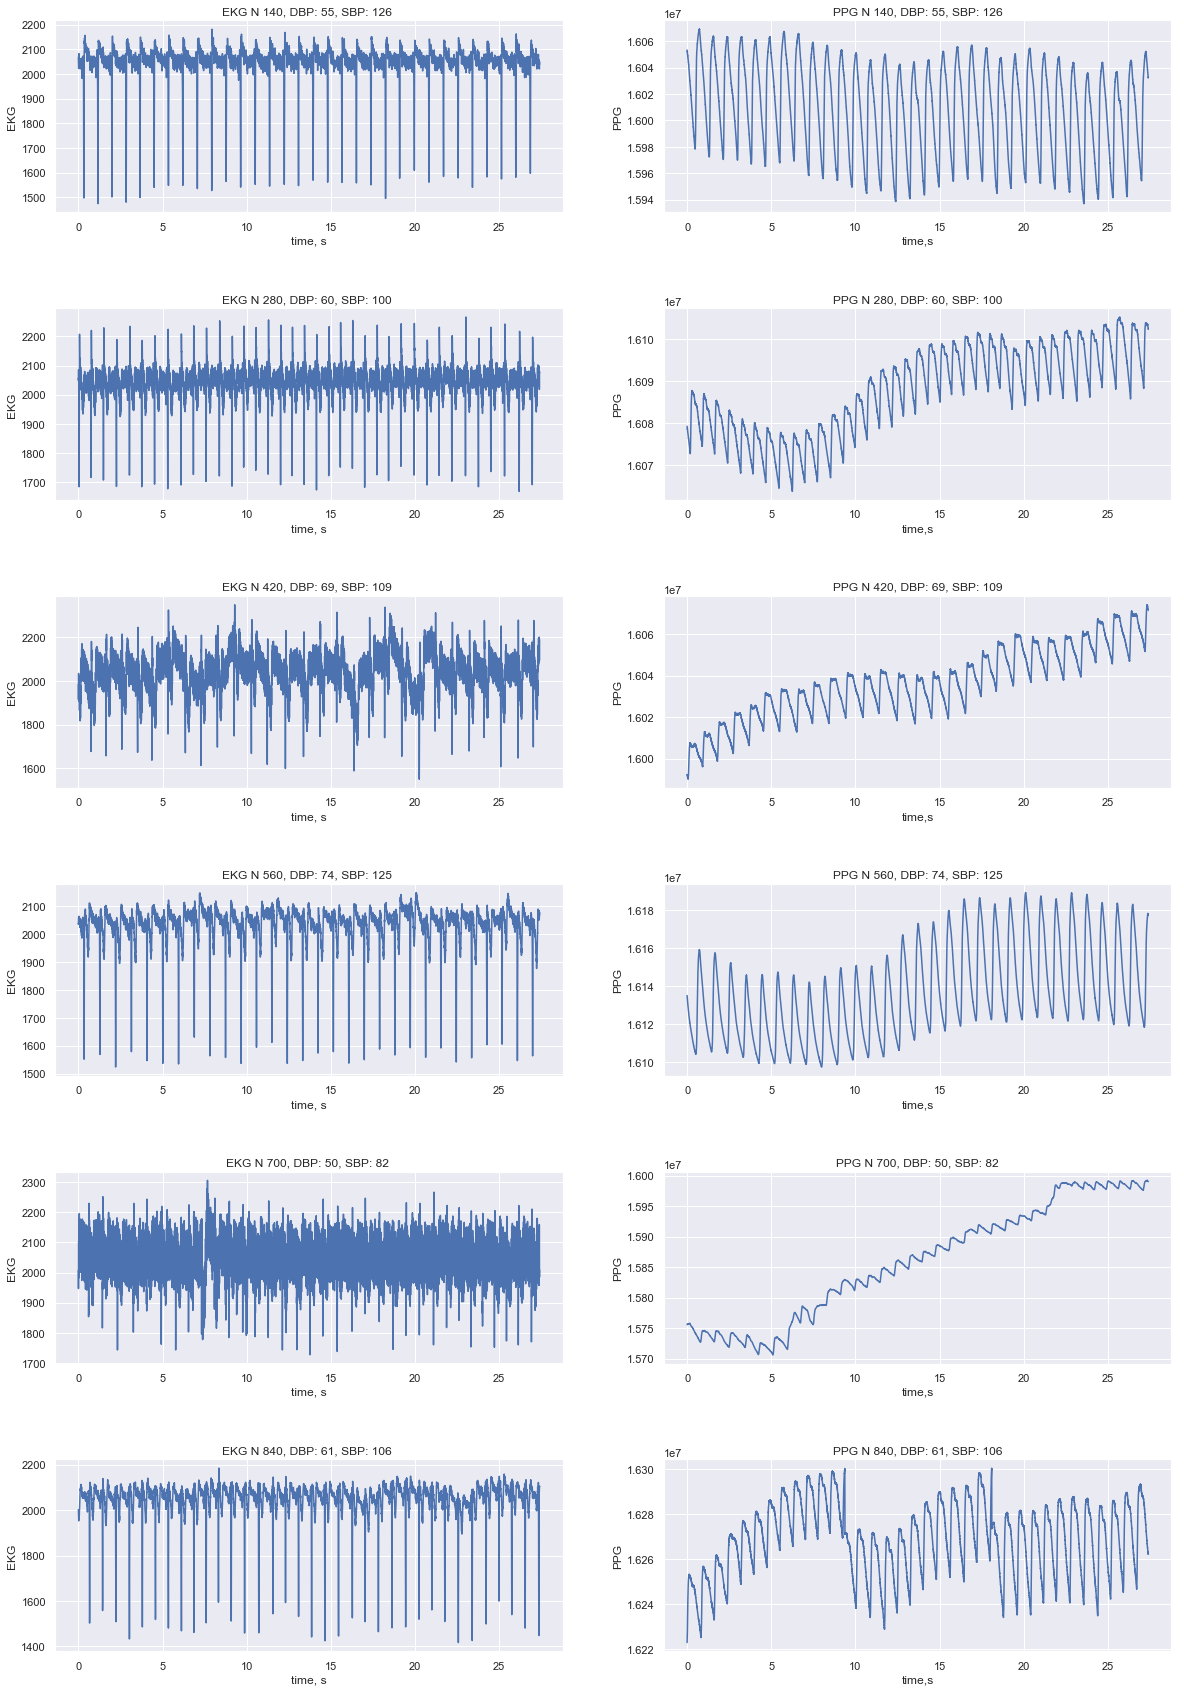

In [19]:
#plotin of input data
m=6 # how many graphs to plot

step = 140 # by which step  plot the graphs

plt.figure(figsize=(20,30))

time = np.arange(EKG_original.shape[1])/500

for i in range(1,m+1):
    
    plt.subplot(m, 2, 2*i-1)
    plt.plot(time,EKG_original[i*step])
    plt.xlabel('time, s')
    plt.ylabel('EKG')
    plt.title('EKG N %d, DBP: %d, SBP: %d '%(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
#     plt.xticks([])
    plt.subplot(m, 2, 2*i)
    plt.plot(time,OXI_original[i*step])
    plt.xlabel('time,s')
    plt.ylabel('PPG')
    plt.title('PPG N %d, DBP: %d, SBP: %d' %(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
    
plt.subplots_adjust(hspace = 0.5)
plt.show()

In plots above, it can be noticed that signals is not clear. There is some noise and trends in signals. For machine learnig algorithms we need to filter this signals and delite noise and trends.

C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


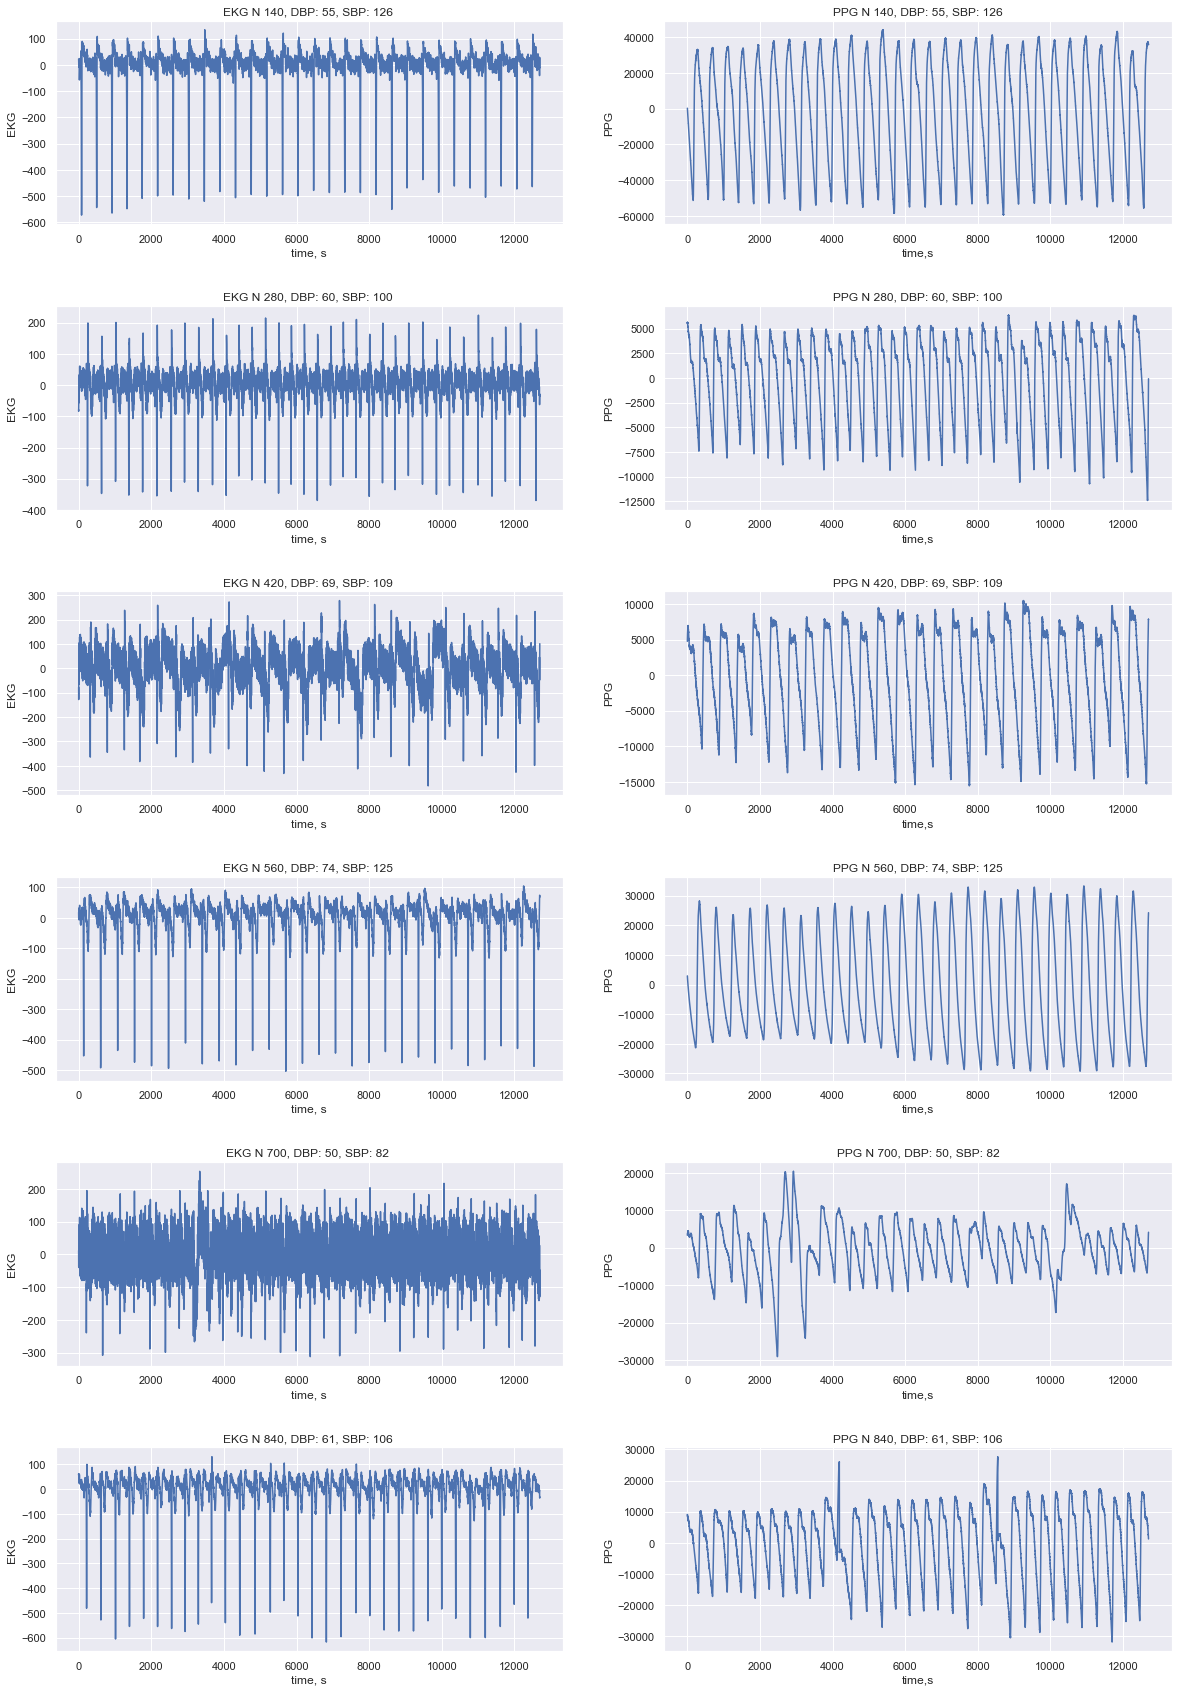

In [20]:
#trend filtering
plt.figure(figsize=(20,30))

time = np.arange(filtr(EKG_original[0,:],1000).shape[0])
#time = np.arange(1000)
for i in range(1,m+1):
    
    plt.subplot(m, 2, 2*i-1)
    plt.plot(time,filtr(EKG_original[i*step,:],1000))
    plt.xlabel('time, s')
    plt.ylabel('EKG')
    plt.title('EKG N %d, DBP: %d, SBP: %d '%(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
#     plt.xticks([])
    plt.subplot(m, 2, 2*i)
    plt.plot(time,filtr(OXI_original[i*step,:],1000))
    plt.xlabel('time,s')
    plt.ylabel('PPG')
    plt.title('PPG N %d, DBP: %d, SBP: %d' %(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
    
plt.subplots_adjust(hspace = 0.4)
plt.show()

Signals could be compared with previous. 

C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


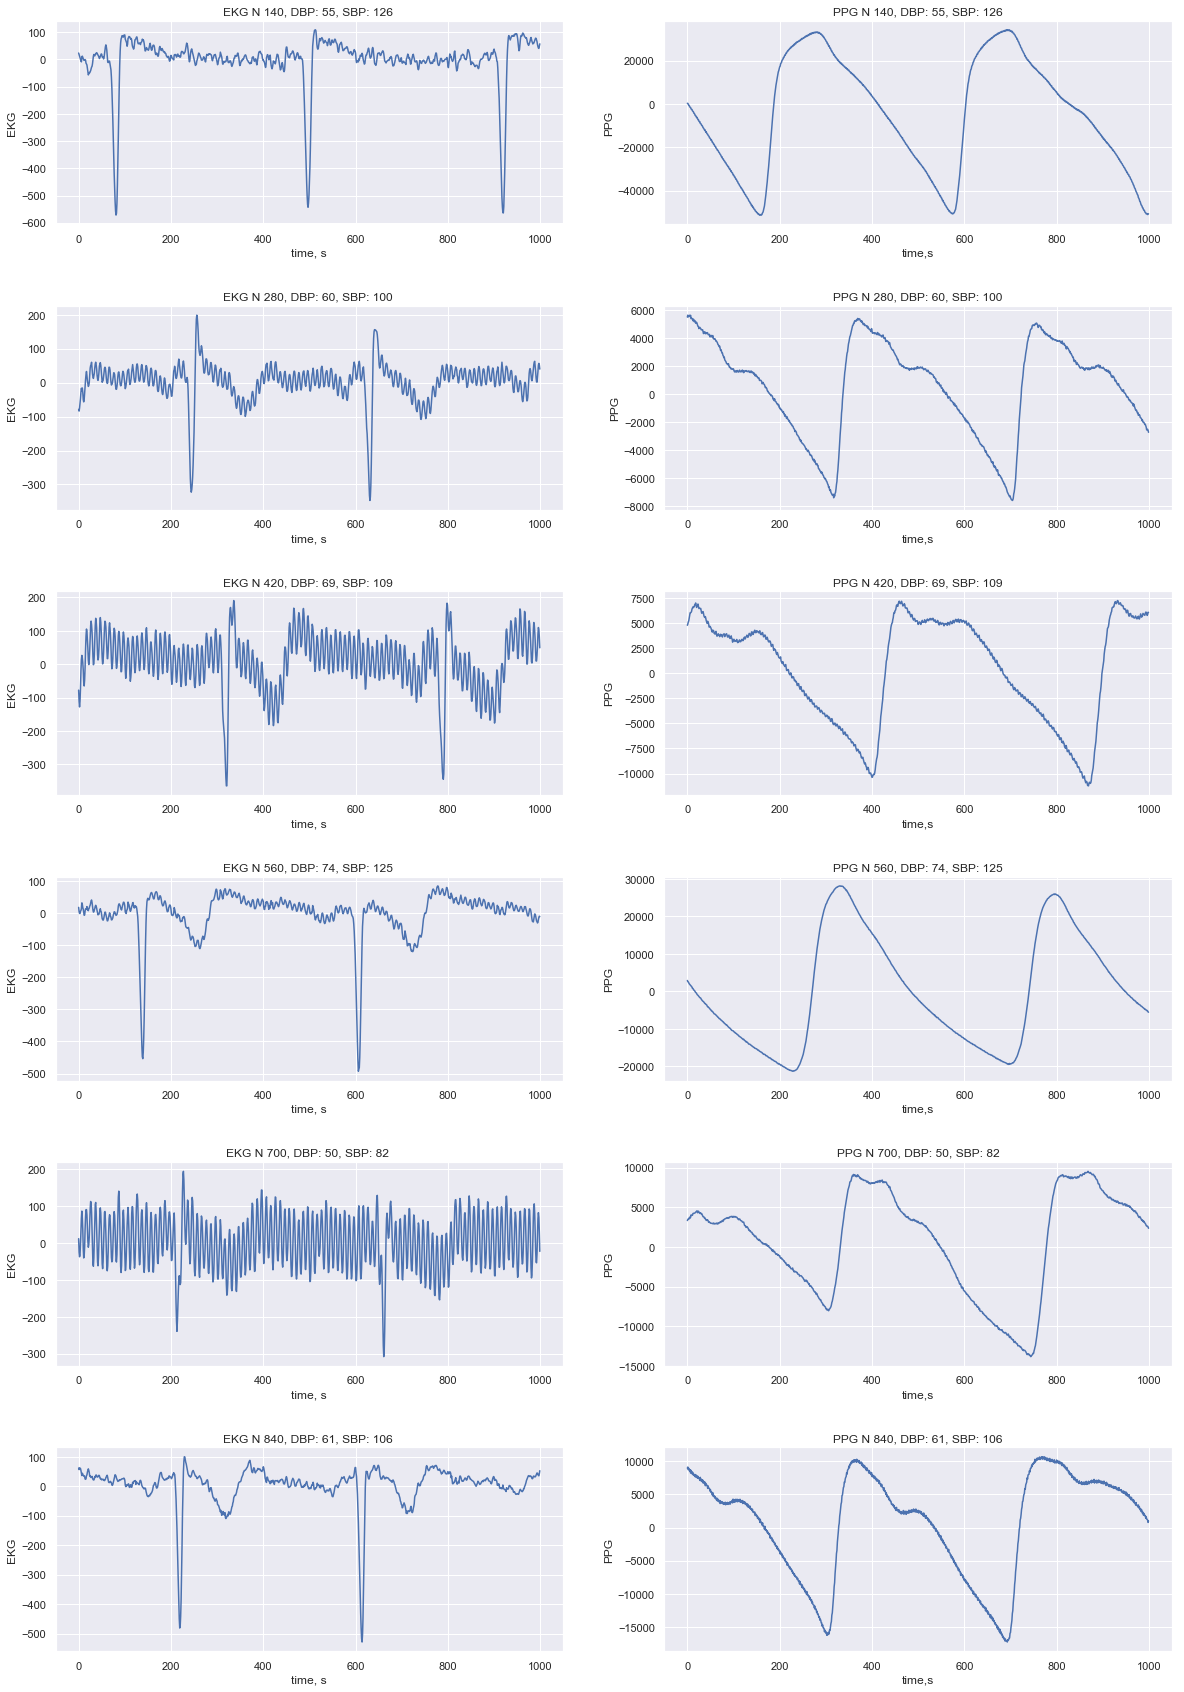

In [21]:
#High harmonics filtering. Butterworth filtering
#Zoom in previous plots
plt.figure(figsize=(20,30))

#time = np.arange(filtrate_trends(EKG_original[0,:],1000).shape[0])
time = np.arange(1000)
for i in range(1,m+1):
    
    plt.subplot(m, 2, 2*i-1)
    plt.plot(time,filtr(EKG_original[i*step,:],1000)[0:1000])
    plt.xlabel('time, s')
    plt.ylabel('EKG')
    plt.title('EKG N %d, DBP: %d, SBP: %d '%(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
#     plt.xticks([])
    plt.subplot(m, 2, 2*i)
    plt.plot(time,filtr(OXI_original[i*step,:],1000)[0:1000])
    plt.xlabel('time,s')
    plt.ylabel('PPG')
    plt.title('PPG N %d, DBP: %d, SBP: %d' %(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
    
plt.subplots_adjust(hspace = 0.4)
plt.show()

C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


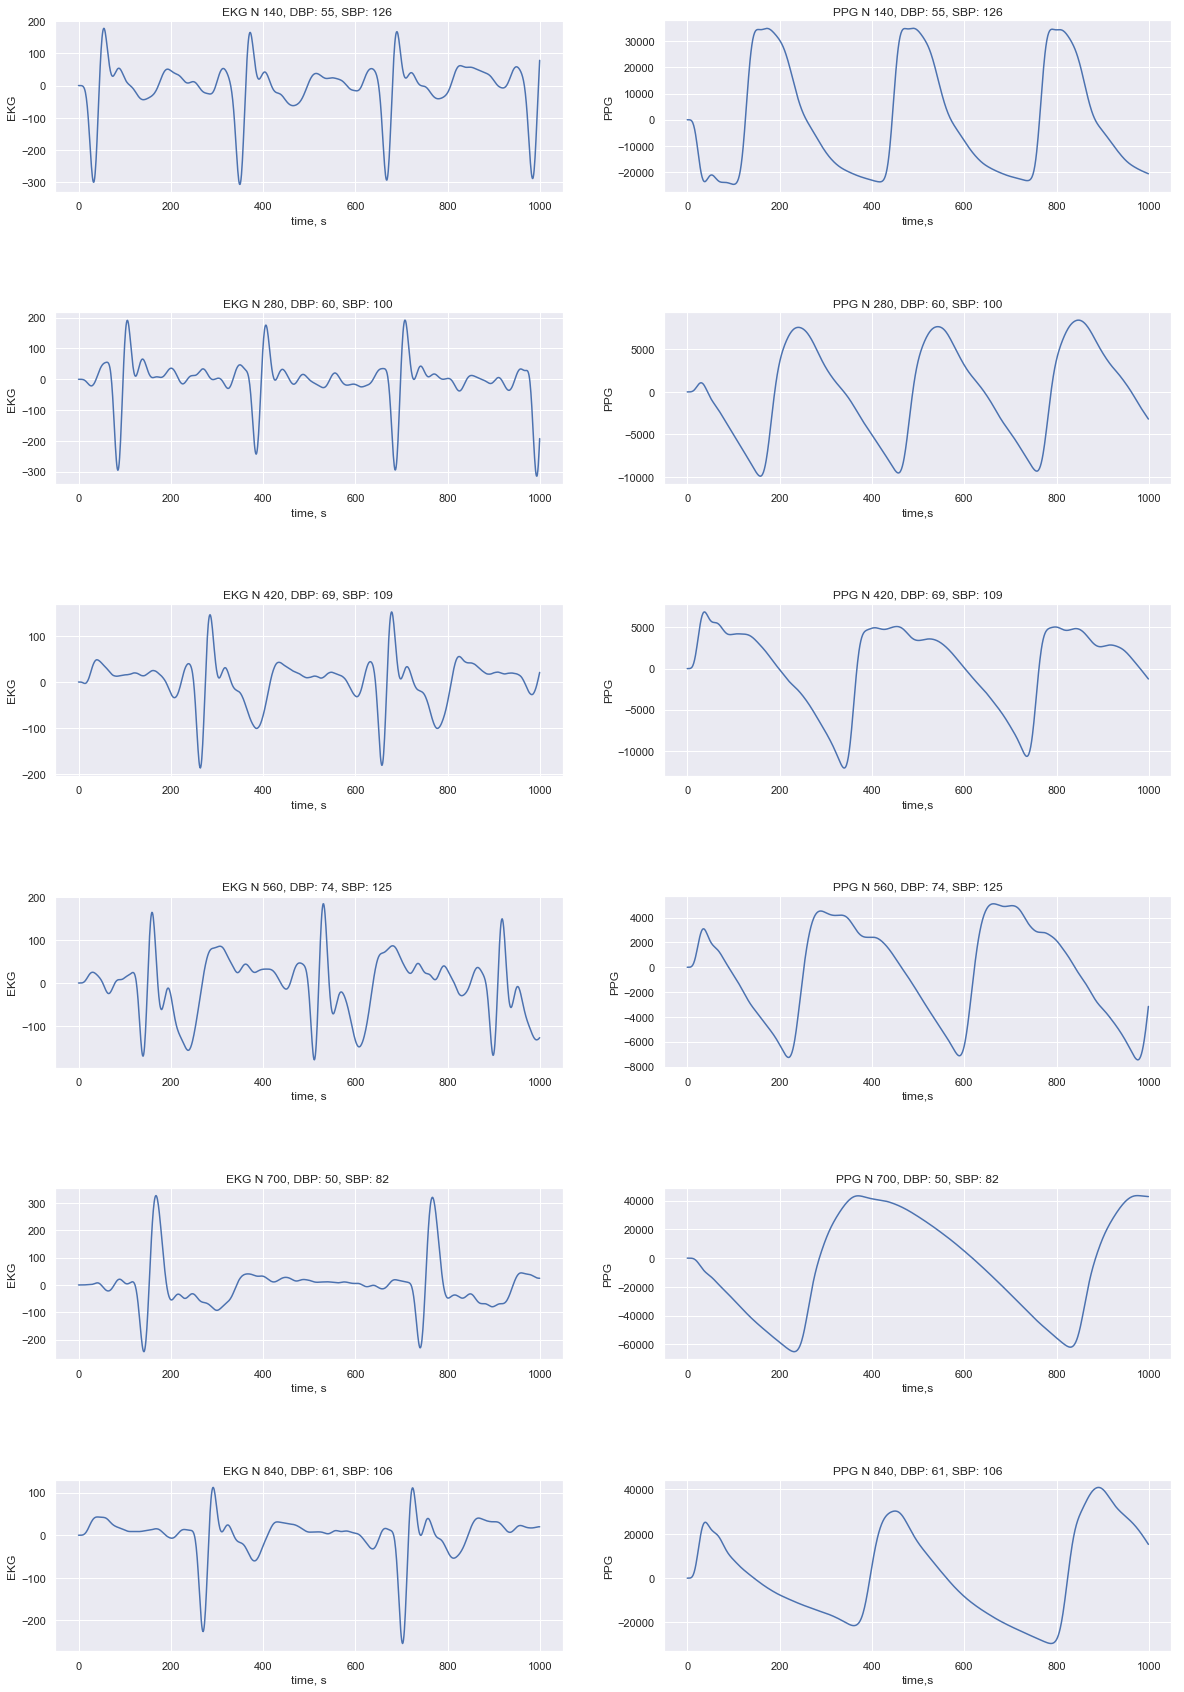

In [22]:
#Apply butterworth filtering
plt.figure(figsize=(20,30))

# Filter requirements.
order = 6
fs = 500.0       # sample rate, Hz
cutoff = 15  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

#time = np.arange(filtrate_trends(EKG_original[i*50,:],1000).shape[0])
time = np.arange(1000)
for i in range(1,m+1):
    
    plt.subplot(m, 2, 2*i-1)
    plt.plot(time,butter_lowpass_filter(filtr(EKG_original[i*90,:],1000), cutoff, fs, order)[0:1000])
    plt.xlabel('time, s')
    plt.ylabel('EKG')
    plt.title('EKG N %d, DBP: %d, SBP: %d '%(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
#     plt.xticks([])
    plt.subplot(m, 2, 2*i)
    plt.plot(time,butter_lowpass_filter(filtr(OXI_original[i*90,:],1000), cutoff, fs, order)[0:1000])
    plt.xlabel('time,s')
    plt.ylabel('PPG')
    plt.title('PPG N %d, DBP: %d, SBP: %d' %(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
    
plt.subplots_adjust(hspace = 0.7)
plt.show()


From graphs plotted above it's very difficult to find dependences between blood preasure and ECG and PPG. We need to find special features to teach our model.

# Features' selection

In [23]:
#Lets check statistical moments on filtered time series
OXI_filtered,EKG_filtered = matrix_filtr(matrix,1000) 
X_filtered = np.concatenate((OXI_filtered,EKG_filtered), axis = 1)[1:,:]
OXI_moments,EKG_moments = moments(OXI_filtered, EKG_filtered, n_moments=5)
X_moments = np.concatenate((OXI_moments,EKG_moments), axis = 1)[1:,::]
DBP = matrix[1:,-1]
SBP = matrix[1:,-2]

C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [24]:
#Normolize our data
scaler = StandardScaler()

X_scaled_moments = scaler.fit_transform(X_moments)

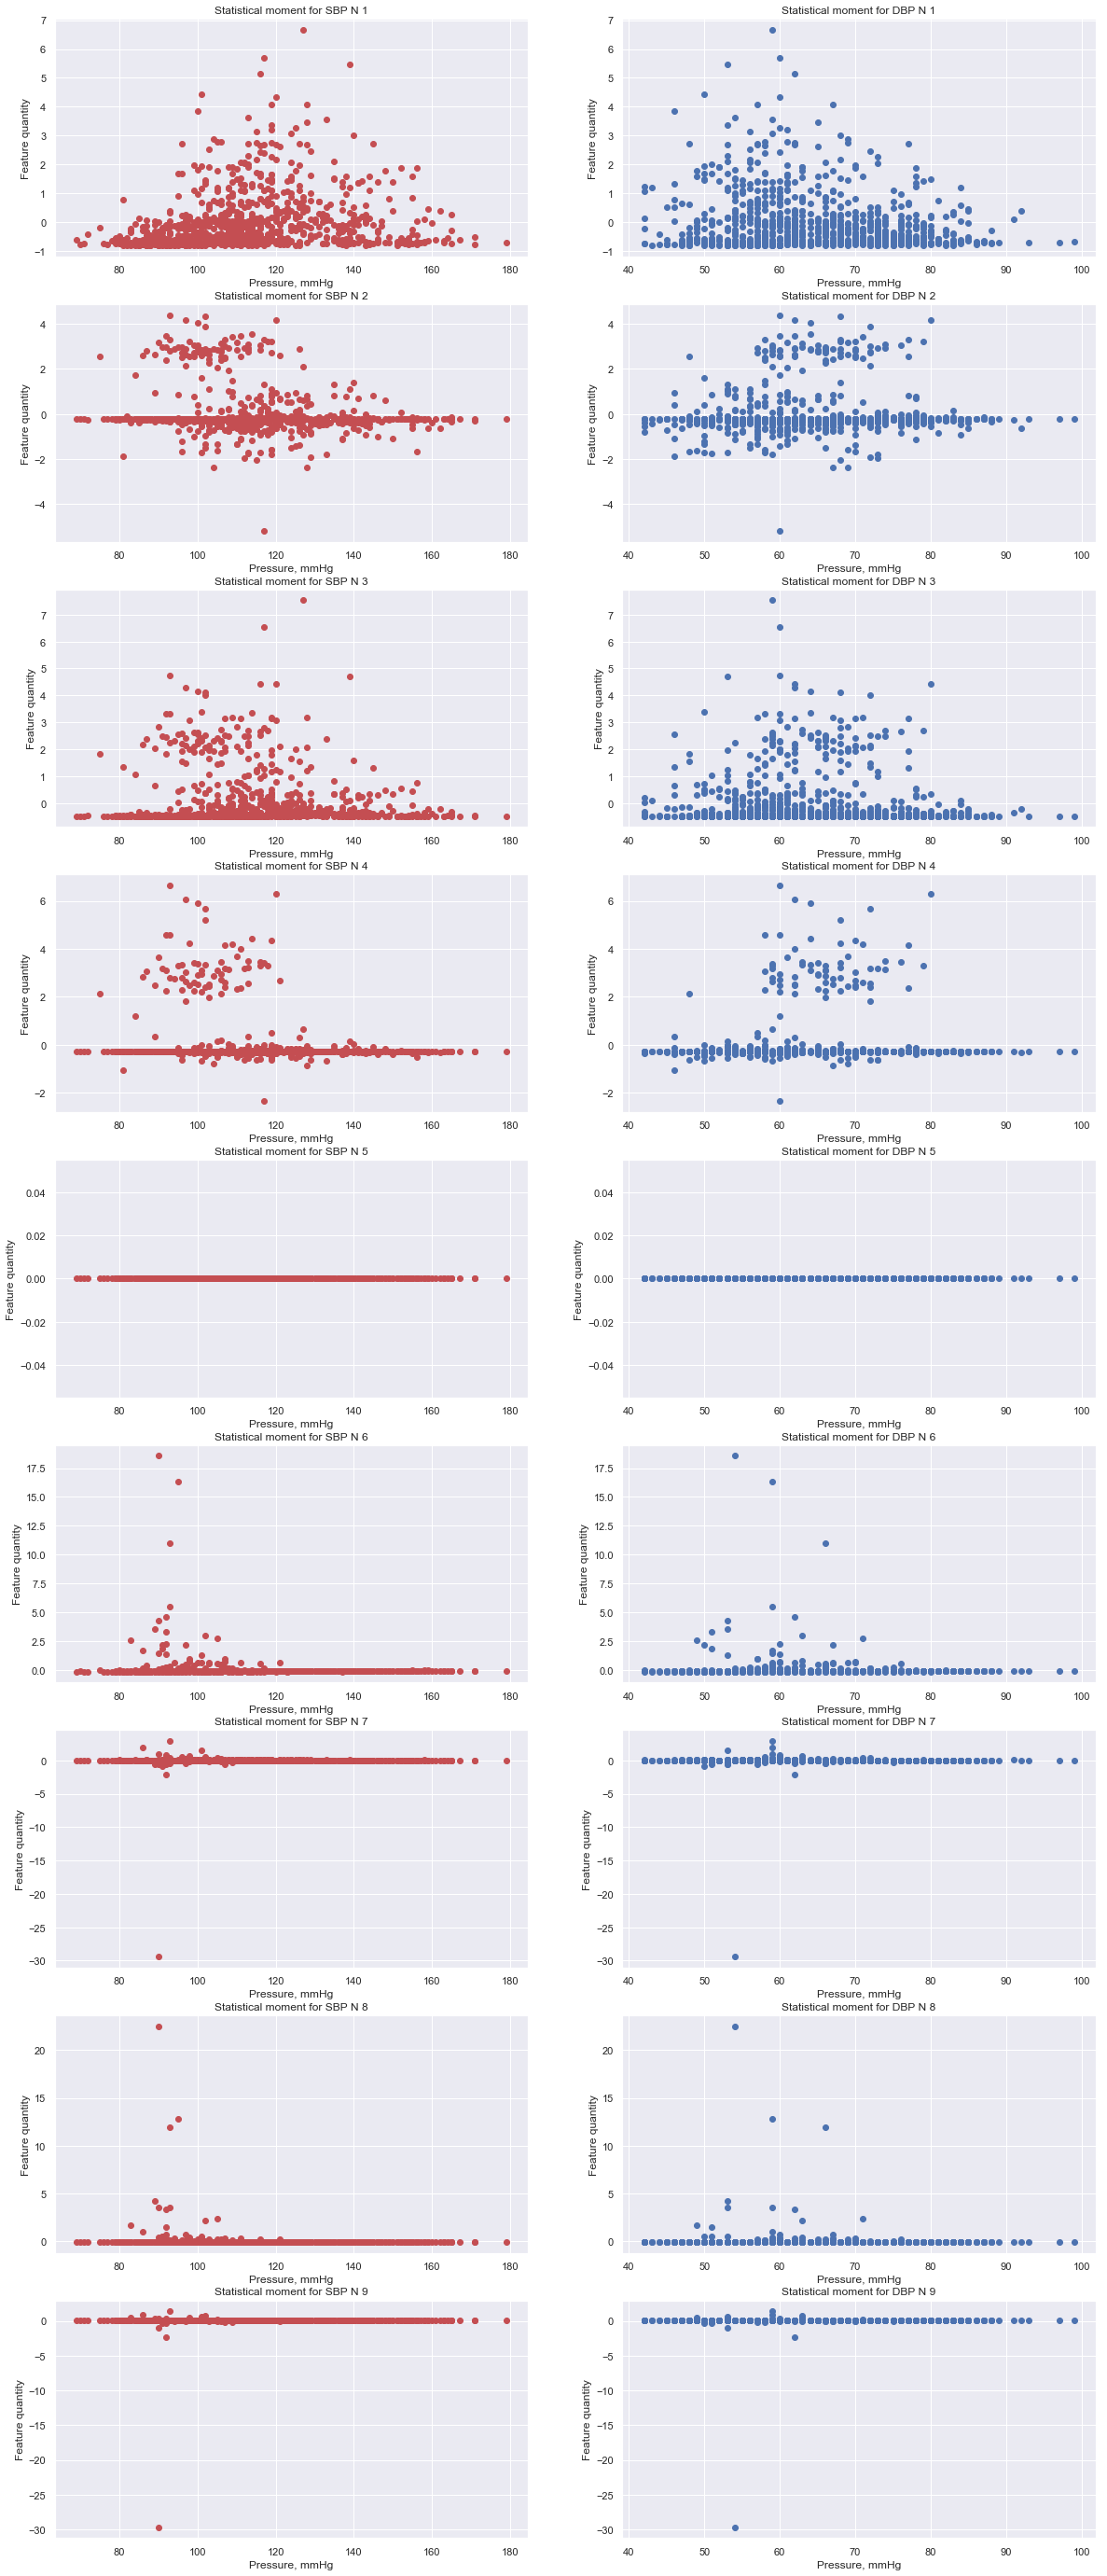

In [25]:
m=9
start=0

plt.figure(figsize=(20,20))

for i in range(1,m+1):
    
    plt.subplot(m, 2, 2*i-1)
    plt.plot(SBP, X_scaled_moments[:,i],'ro')
    plt.xlabel('Pressure, mmHg')
    plt.ylabel('Feature quantity')
    plt.title('Statistical moment for SBP N %d'%(i))
#     plt.xticks([])
    plt.subplot(m, 2, 2*i)
    plt.plot(DBP, X_scaled_moments[:,i],'bo')
    plt.xlabel('Pressure, mmHg')
    plt.ylabel('Feature quantity')
    plt.title('Statistical moment for DBP N %d'%(i))
    
plt.subplots_adjust(top=2)
plt.show()

As you can see moments can not provide a good information about preasure distribution according feature changes.
Let's calculate anothe features: 'signal mobility', 'signal complexity', 'entropy', 'mean value', 'std'. Also, we devide our presure values into 7 classes: 'Hypotention', 'Normal', 'Prehypertention', 'Stage 1 hypertension', 'Stage 2 hypertension', 'Isolated systolic hypertennsion', 'Hypertensive crisis'.

In [26]:
#here we upload data with calculated features
X_train_feat,Y_train1_feat,Y_train2_feat,ID_train_feat, Y_train_clas = read_data_feat('data_train')

C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
C:\Users\maxel\Anaconda33\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\maxel\Anaconda33\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
#Classes of preasure
Y_train_clas.head()

,Hypotention,Normal,Prehypertention,Stage 1 hypertension,Stage 2 hypertension,Isolated systolic hypertennsion,Hypertensive crisis
673,0,0,1,0,0,0,0
674,0,0,0,1,0,0,0
675,0,0,0,1,0,0,0
676,0,1,0,0,0,0,0
677,0,1,0,0,0,0,0


In [28]:
#features
X_train_feat.head()

,PWTT,Entr,Mob,Comp,Mean_PPG,Mean_ECG,STD_PPG,STD_ECG,max_PPG,max_ECG,min_PPG,min_ECG
673,344.375000,8.511295,0.096932,0.117073,172.832599,-0.467825,6341.993537,52.530400,7940.791092,186.082749,-11239.687593,-166.565881
674,290.300000,8.511572,0.093205,0.122908,-275.389899,22.910899,1810.126152,75.570779,2999.248466,239.880836,-3588.757274,-182.996836
675,315.666667,8.508695,0.105411,0.109151,179.265539,1.633243,5644.600618,55.283303,6854.760241,195.730933,-11084.429959,-162.178568
676,182.000000,8.509631,0.096088,0.118735,60.672233,1.593493,9280.784813,55.370785,13912.748606,190.279970,-16309.361889,-160.097230
677,325.888889,8.509250,0.097544,0.117333,307.534683,-6.431549,8885.149927,55.609390,15665.863497,172.846964,-14593.883419,-181.978864


In [29]:
#let's normalise input data
scaler = StandardScaler()
X_train_f = pd.DataFrame(scaler.fit_transform(X_train_feat), columns=X_train_feat.columns,index=X_train_feat.index)
X_train_f.head()

,PWTT,Entr,Mob,Comp,Mean_PPG,Mean_ECG,STD_PPG,STD_ECG,max_PPG,max_ECG,min_PPG,min_ECG
673,1.927129,0.307652,0.072428,0.812380,0.123710,-0.021507,-0.850192,-0.689428,-0.917966,0.196561,0.869596,0.795129
674,1.156748,0.383611,-0.132031,1.293824,-0.238778,1.542251,-1.319817,0.441363,-1.267777,0.873226,1.388490,0.620525
675,1.518135,-0.404654,0.537582,0.158688,0.128913,0.119029,-0.922461,-0.554319,-0.994846,0.317914,0.880126,0.841750
676,-0.386150,-0.148105,0.026125,0.949518,0.033004,0.116370,-0.545654,-0.550026,-0.495213,0.249353,0.525766,0.863868
677,1.663766,-0.252735,0.105995,0.833822,0.232647,-0.420410,-0.586652,-0.538315,-0.371110,0.030083,0.642111,0.631343


In [30]:
#here we exclude data, that has noise intead of measurements
X_train_feat = X_train_feat[ID_train_feat['ID']!=7]
X_train_f = X_train_f[ID_train_feat['ID']!=7]
Y_train1_feat = Y_train1_feat[ID_train_feat['ID']!=7]
Y_train2_feat = Y_train2_feat[ID_train_feat['ID']!=7]
Y_train_clas = Y_train_clas[ID_train_feat['ID']!=7]
ID_train_feat = ID_train_feat[ID_train_feat['ID']!=7]
X_train_f = X_train_f[ID_train_feat['ID']!=11]
X_train_feat = X_train_feat[ID_train_feat['ID']!=11]
Y_train1_feat = Y_train1_feat[ID_train_feat['ID']!=11]
Y_train2_feat = Y_train2_feat[ID_train_feat['ID']!=11]
Y_train_clas = Y_train_clas[ID_train_feat['ID']!=11]
ID_train_feat = ID_train_feat[ID_train_feat['ID']!=11]

In [31]:
#Let's plot distribution of classes
Y_plot = pd.concat([X_train_f,Y_train_clas],axis=1)
Y_plot.head(10)

,PWTT,Entr,Mob,Comp,Mean_PPG,Mean_ECG,STD_PPG,STD_ECG,max_PPG,max_ECG,min_PPG,min_ECG,Hypotention,Normal,Prehypertention,Stage 1 hypertension,Stage 2 hypertension,Isolated systolic hypertennsion,Hypertensive crisis
847,-0.257931,-0.224064,0.537096,-0.834503,0.249192,0.175544,1.622548,1.153261,2.098585,0.224721,-0.683094,-1.094314,1,0,0,0,0,0,0
848,-0.548204,-0.224064,0.272400,-0.353943,0.059544,0.049016,1.818416,-0.069685,1.838108,-0.255919,-1.414983,-0.897267,0,1,0,0,0,0,0
850,-1.012997,0.079773,-0.307522,0.447182,-0.188112,0.212050,0.452446,-0.205601,0.639356,-0.991088,-0.111843,-0.301374,0,0,0,1,0,0,0
851,0.055492,0.307652,0.502791,-0.517460,-0.123298,0.285688,0.438415,0.448723,0.276566,-0.450203,-0.379241,-0.582070,1,0,0,0,0,0,0
852,-0.058480,-0.300024,0.629520,-0.797523,0.390681,-0.151597,1.749182,0.341254,2.296318,0.044674,-0.880862,-0.565009,1,0,0,0,0,0,0
853,0.200548,0.231692,0.510102,-0.438008,0.328977,-0.059385,0.861220,0.295509,0.943904,-0.029769,-0.411177,-0.568666,1,0,0,0,0,0,0
854,-0.229438,0.763408,0.344565,-0.458718,0.500317,-0.155168,1.409824,1.132500,1.626152,-0.138686,-0.584149,-0.994793,0,1,0,0,0,0,0
855,-0.281675,0.915327,0.571374,-0.884457,0.379420,0.353967,1.530270,1.109310,1.819711,0.309864,-0.605803,-1.273664,1,0,0,0,0,0,0
856,-1.190431,-0.983658,0.536424,-0.683361,-2.970817,0.192698,1.797304,0.945096,2.378629,0.492539,-1.140858,-1.655054,0,0,1,0,0,0,0
857,-0.628341,0.535530,0.548696,-0.854225,0.396968,0.271216,0.808396,1.407163,0.797530,0.440204,-0.262368,-1.448908,0,0,1,0,0,0,0


C:\Users\maxel\Anaconda33\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Maximum value of PPG')

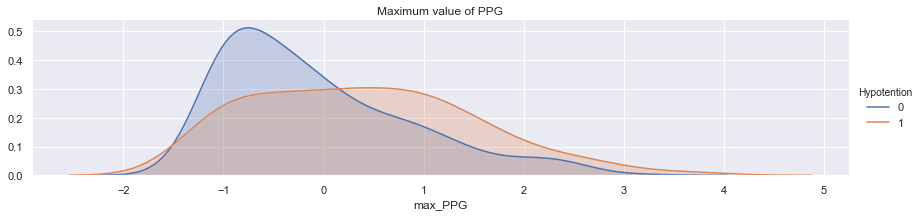

In [32]:
fg = sns.FacetGrid(Y_plot, hue = 'Hypotention',aspect = 4)
fg.map(sns.kdeplot, 'max_PPG' , shade=True)
fg.add_legend()
plt.title("Maximum value of PPG")

C:\Users\maxel\Anaconda33\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'STD of ECG')

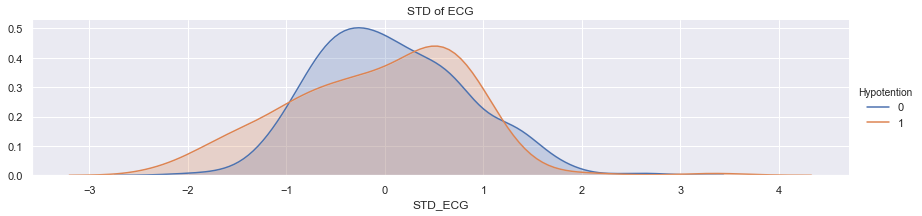

In [33]:
fg = sns.FacetGrid(Y_plot, hue = 'Hypotention',aspect = 4)
fg.map(sns.kdeplot, 'STD_ECG' , shade=True)
fg.add_legend()
plt.title("STD of ECG")

C:\Users\maxel\Anaconda33\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Complexity signal')

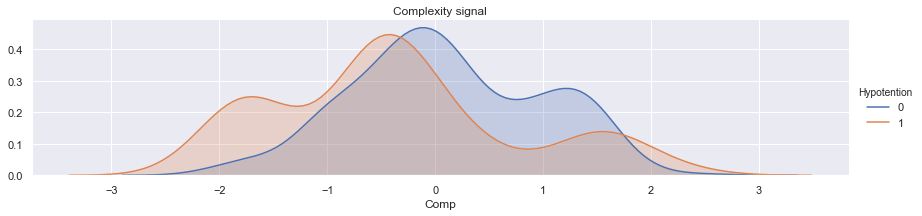

In [34]:
fg = sns.FacetGrid(Y_plot, hue = 'Hypotention',aspect = 4)
fg.map(sns.kdeplot, 'Comp' , shade=True)
fg.add_legend()
plt.title("Complexity signal")

For classification we can find features that can help to divide presure into classes.
But let's look at regression analisys

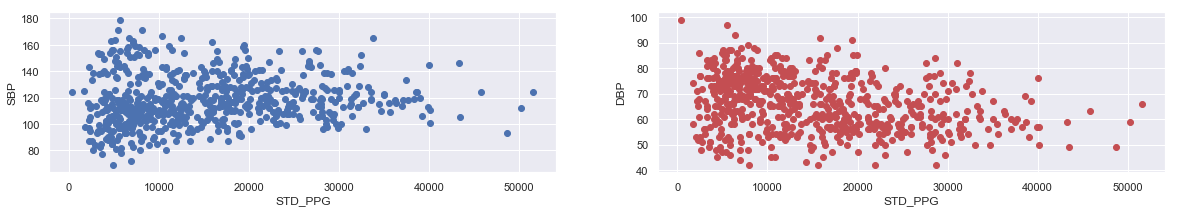

In [35]:
plt.figure(figsize=(20,10))

plt.subplot(3, 2, 1)
plt.plot(X_train_feat['STD_PPG'],Y_train1_feat,'bo')
# plt.title('Target -1, set #0')
plt.ylabel('SBP')
plt.xlabel('STD_PPG')

plt.subplot(3, 2, 2)
plt.plot(X_train_feat['STD_PPG'],Y_train2_feat,'ro')
# plt.title('Target 1, set #3')
plt.ylabel('DBP')
plt.xlabel('STD_PPG')        
plt.show()      

     

plt.show()   

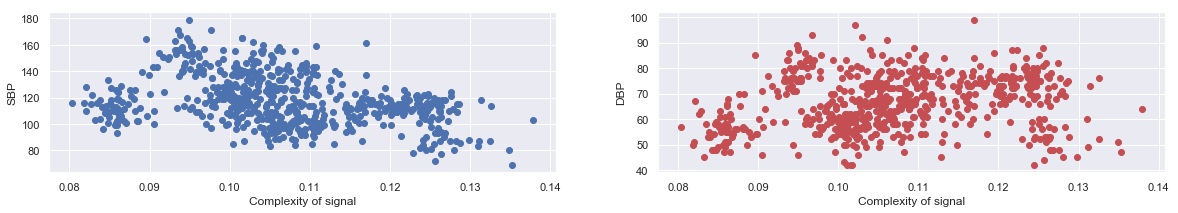

In [36]:
plt.figure(figsize=(20,10))
plt.subplot(3, 2, 3)
plt.plot(X_train_feat['Comp'],Y_train1_feat,'bo')
# plt.title('Target -1, set #0')
plt.ylabel('SBP')
plt.xlabel('Complexity of signal')

plt.subplot(3, 2, 4)
plt.plot(X_train_feat['Comp'],Y_train2_feat,'ro')
# plt.title('Target 1, set #3')
plt.ylabel('DBP')
plt.xlabel('Complexity of signal')  
plt.show() 

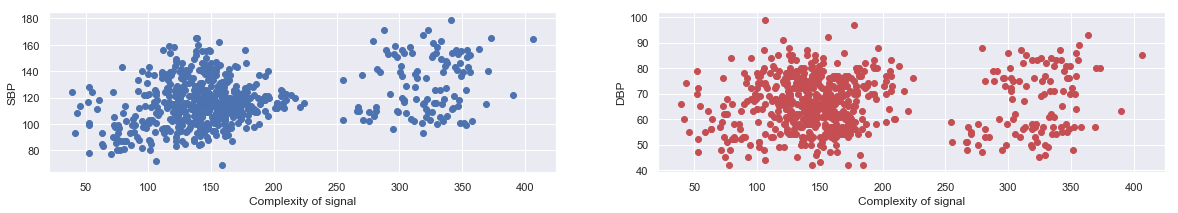

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(3, 2, 3)
plt.plot(X_train_feat['max_ECG'],Y_train1_feat,'bo')
# plt.title('Target -1, set #0')
plt.ylabel('SBP')
plt.xlabel('Complexity of signal')

plt.subplot(3, 2, 4)
plt.plot(X_train_feat['max_ECG'],Y_train2_feat,'ro')
# plt.title('Target 1, set #3')
plt.ylabel('DBP')
plt.xlabel('Complexity of signal')  
plt.show() 

Here it's not so obvious tha му can find a function to predict preassure values.
Let's try to predict pressure values based on our features.

# Machine learning algorithms

First of all we decided to use 'KNeighbourRegressor to predict target values. For spliting our data to test and train sets we used 'KFold'. As metrics it was used: 'neg_mean_squared_error', 'neg_mean_absolute_error', 'explained_variance'.

In [365]:
#SBP prediction
kfold = StratifiedKFold(n_splits=5)
KN = KNeighborsRegressor(n_neighbors = 2)
cv = kfold.split(X_train_f, Y_train1_feat)
scores1 = cross_val_score(KN, X_train_f, Y_train1_feat, scoring='neg_mean_squared_error', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
scores2 = cross_val_score(KN, X_train_f, Y_train1_feat, scoring='neg_mean_absolute_error', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
scores3 = cross_val_score(KN, X_train_f, Y_train1_feat, scoring='explained_variance', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
scores4 = cross_val_score(KN, X_train_f, Y_train1_feat, scoring='r2', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
predict = cross_val_predict(KN, X_train_f, Y_train1_feat, cv=cv)
print('Neg_mean_squared_error metric:  {}'.format(np.mean(scores1)))
print('Neg_mean_absolute_error metric:  {}'.format(np.mean(scores2)))
print('Explained_variance metric:  {}'.format(np.mean(scores3)))
print('R2 metric:  {}'.format(np.mean(scores4)))

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

Neg_mean_squared_error metric:  -235.35941903227248
Neg_mean_absolute_error metric:  -12.063752656634657
Explained_variance metric:  0.2060991415866526
R2 metric:  0.1996155450520527


C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


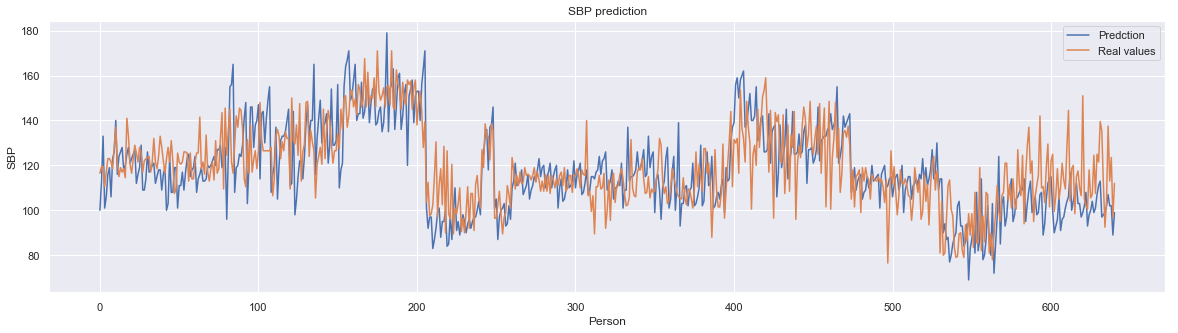

In [361]:
plt.figure(figsize=(20,5))

plt.plot(Y_train1_feat.values)
plt.plot(predict)
plt.title('SBP prediction')
plt.ylabel('SBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

In [366]:
#DBP prediction
cv = kfold.split(X_train_f, Y_train2_feat)
scores1 = cross_val_score(KN, X_train_f, Y_train2_feat, scoring='neg_mean_squared_error', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
scores2 = cross_val_score(KN, X_train_f, Y_train2_feat, scoring='neg_mean_absolute_error', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
scores3 = cross_val_score(KN, X_train_f, Y_train2_feat, scoring='explained_variance', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
scores4 = cross_val_score(KN, X_train_f, Y_train2_feat, scoring='r2', cv=cv)
cv = kfold.split(X_train_f, Y_train1_feat)
predict = cross_val_predict(KN, X_train_f, Y_train2_feat, cv=cv)
print('Neg_mean_squared_error metric:  {}'.format(np.mean(scores1)))
print('Neg_mean_absolute_error metric:  {}'.format(np.mean(scores2)))
print('Explained_variance metric:  {}'.format(np.mean(scores3)))
print('R2:  {}'.format(np.mean(scores4)))

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

Neg_mean_squared_error metric:  -87.5869655603582
Neg_mean_absolute_error metric:  -7.3103362498543305
Explained_variance metric:  0.10217735358342384
R2:  0.028015502047444917


C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


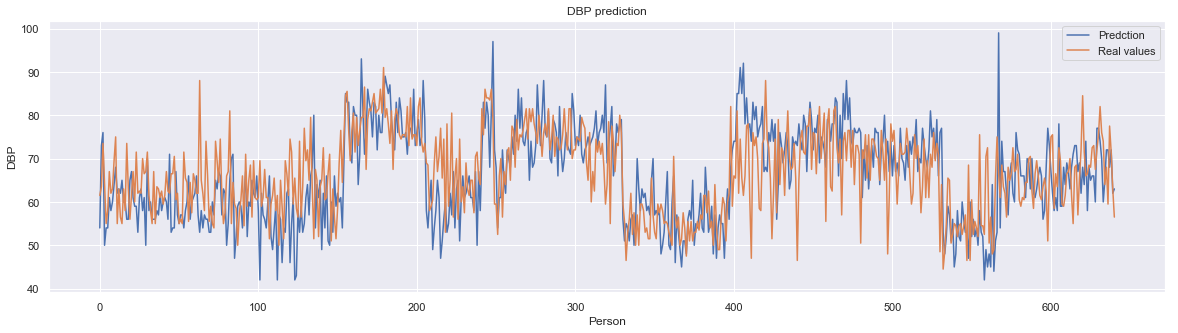

In [363]:
plt.figure(figsize=(20,5))


plt.plot(Y_train2_feat.values)
plt.plot(predict)
plt.title('DBP prediction')
plt.ylabel('DBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

Now let's check how we can solve it by different algorithms

In [367]:
#SBP prediction
test = pd.DataFrame()

kfold = StratifiedKFold(n_splits=5)
KN = KNeighborsRegressor(n_neighbors = 2)
SVR = svm.SVR(kernel='linear')
GB = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
Rid = Ridge (alpha = .1)
XGB = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
CLS=[KN,SVR,GB,Rid,XGB]
CLS_name = ['KN','SVR','GB','Rid','XGB']
for j in range(len(CLS)):

    cv = kfold.split(X_train_f, Y_train1_feat)
    scores1 = cross_val_score(CLS[j], X_train_f, Y_train1_feat, scoring='neg_mean_squared_error', cv=cv)
    cv = kfold.split(X_train_f, Y_train1_feat)
    scores2 = cross_val_score(CLS[j], X_train_f, Y_train1_feat, scoring='neg_mean_absolute_error', cv=cv)
    cv = kfold.split(X_train_f, Y_train1_feat)
    scores3 = cross_val_score(CLS[j], X_train_f, Y_train1_feat, scoring='explained_variance', cv=cv)
    cv = kfold.split(X_train_f, Y_train1_feat)
    scores4 = cross_val_score(CLS[j], X_train_f, Y_train1_feat, scoring='r2', cv=cv)
        
    test.loc[CLS_name[j],'neg_mean_squared_error']=scores1.mean()
    test.loc[CLS_name[j],'neg_mean_absolute_error']=scores2.mean()
    test.loc[CLS_name[j],'explained_variance']=scores3.mean()
    test.loc[CLS_name[j],'R2']=scores4.mean()
test     

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any clas

,neg_mean_squared_error,neg_mean_absolute_error,explained_variance,R2
KN,-235.359419,-12.063753,0.206099,0.199616
SVR,-238.353366,-12.023549,0.213384,0.196258
GB,-203.400619,-11.401851,0.342478,0.333611
Rid,-229.573927,-12.250829,0.256250,0.243631
XGB,-178.434156,-10.403400,0.434412,0.424808


In [369]:
#SBP prediction
test = pd.DataFrame()

kfold = StratifiedKFold(n_splits=5)
KN = KNeighborsRegressor(n_neighbors = 2)
SVR = svm.SVR(kernel='linear')
GB = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
Rid = Ridge (alpha = .1)
XGB = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
CLS=[KN,SVR,GB,Rid,XGB]
CLS_name = ['KN','SVR','GB','Rid','XGB']
for j in range(len(CLS)):

    cv = kfold.split(X_train_f, Y_train2_feat)
    scores1 = cross_val_score(CLS[j], X_train_f, Y_train2_feat, scoring='neg_mean_squared_error', cv=cv)
    cv = kfold.split(X_train_f, Y_train2_feat)
    scores2 = cross_val_score(CLS[j], X_train_f, Y_train2_feat, scoring='neg_mean_absolute_error', cv=cv)
    cv = kfold.split(X_train_f, Y_train2_feat)
    scores3 = cross_val_score(CLS[j], X_train_f, Y_train2_feat, scoring='explained_variance', cv=cv)
    cv = kfold.split(X_train_f, Y_train2_feat)
    scores4 = cross_val_score(CLS[j], X_train_f, Y_train2_feat, scoring='r2', cv=cv)
        
    test.loc[CLS_name[j],'neg_mean_squared_error']=scores1.mean()
    test.loc[CLS_name[j],'neg_mean_absolute_error']=scores2.mean()
    test.loc[CLS_name[j],'explained_variance']=scores3.mean()
    test.loc[CLS_name[j],'R2']=scores4.mean()

test     

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

,neg_mean_squared_error,neg_mean_absolute_error,explained_variance,R2
KN,-87.586966,-7.116019,0.193886,0.182595
SVR,-94.758746,-7.503700,0.116269,0.107773
GB,-76.367191,-6.974818,0.302475,0.296323
Rid,-94.131545,-7.647381,0.134091,0.124492
XGB,-63.111576,-6.126200,0.430362,0.421370


Compare all getting results, we can see that the best solution can give 'XGBRegressor'. Let's check it on the plot

In [342]:
#SBP prediction
kfold = StratifiedKFold(n_splits=5)
XGB = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

cv = kfold.split(X_train_f, Y_train1_feat)
predict1 = cross_val_predict(XGB, X_train_f, Y_train1_feat, cv=cv)

#DBP prediction

cv = kfold.split(X_train_f, Y_train1_feat)
predict2 = cross_val_predict(XGB, X_train_f, Y_train2_feat, cv=cv)


C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


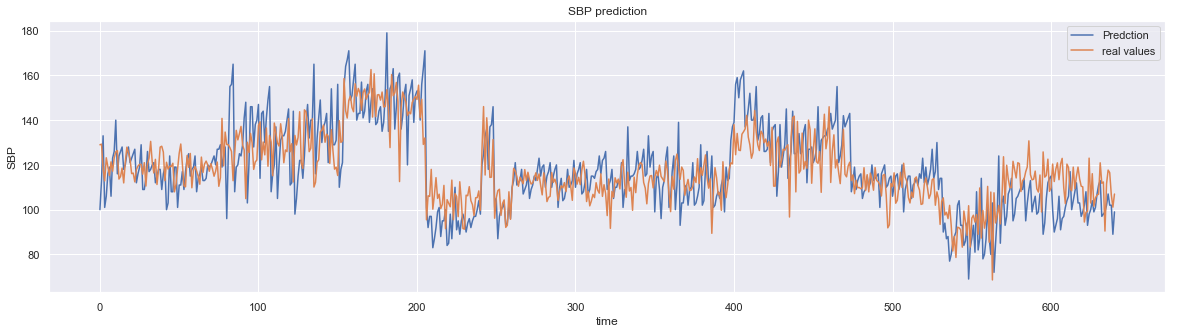

In [343]:
plt.figure(figsize=(20,5))

plt.plot(Y_train1_feat.values)
plt.plot(predict1)
plt.title('SBP prediction')
plt.ylabel('SBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

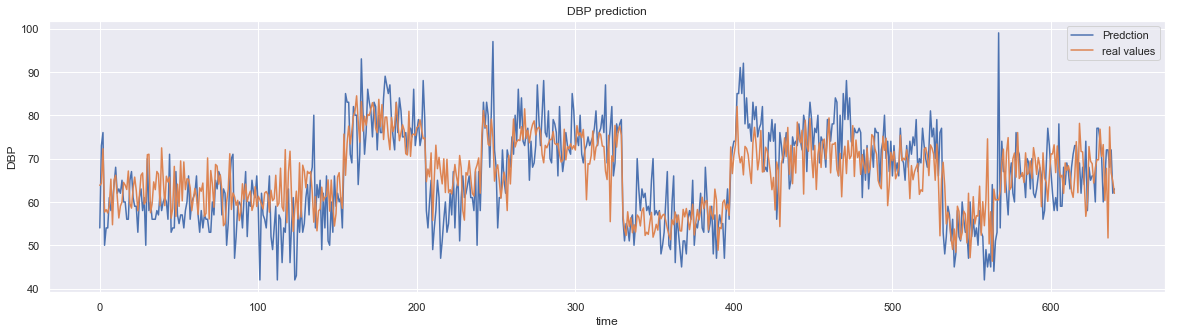

In [345]:
plt.figure(figsize=(20,5))


plt.plot(Y_train2_feat.values)
plt.plot(predict2)
plt.title('DBP prediction')
plt.ylabel('DBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

It can be noticed that results is not so good. Error still is high. But in our case, it is the best accuracy that we got.

Additionally, let's check how we can estimate class validation for one of the classes

In [346]:
kfold = StratifiedKFold(n_splits=5)
KNC = KNeighborsClassifier(n_neighbors=50)

cv = kfold.split(X_train_f, Y_train_clas.iloc[:,1])
scores = cross_val_score(KNC, X_train_f, Y_train_clas.iloc[:,1], scoring='roc_auc', cv=cv)
        

print('Average KFold score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

Average KFold score: 0.741 ± 0.230


In the class validation accuracy is not so bad: 0.74

# Machin learning with real data

Here we just decided to put as an imput to the model real data without transformation

In [283]:
#upload real data without transformation
X_train1,X_train2,Y_train1,Y_train2,ID_train = read_data_real('data_train')

In [284]:
#concatenate DataFrames
X_train = pd.concat([X_train1,X_train2],axis=1)

In [372]:
#SBP prediction
kfold = StratifiedKFold(n_splits=5)
KN = KNeighborsRegressor(n_neighbors = 2)
cv = kfold.split(X_train, Y_train1)
scores1 = cross_val_score(KN, X_train, Y_train1, scoring='neg_mean_squared_error', cv=cv)
cv = kfold.split(X_train, Y_train1)
scores2 = cross_val_score(KN, X_train, Y_train1, scoring='neg_mean_absolute_error', cv=cv)
cv = kfold.split(X_train, Y_train1)
scores3 = cross_val_score(KN, X_train, Y_train1, scoring='explained_variance', cv=cv)
cv = kfold.split(X_train, Y_train1)
scores3 = cross_val_score(KN, X_train, Y_train1, scoring='r2', cv=cv)
cv = kfold.split(X_train, Y_train1)
predict = cross_val_predict(KN, X_train, Y_train1, cv=cv)
print('Neg_mean_squared_error metric:  {}'.format(np.mean(scores1)))
print('Neg_mean_absolute_error metric:  {}'.format(np.mean(scores2)))
print('Explained_variance metric:  {}'.format(np.mean(scores3)))
print('R2 metric:  {}'.format(np.mean(scores4)))

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

Neg_mean_squared_error metric:  -548.8822401662164
Neg_mean_absolute_error metric:  -17.81581119835289
Explained_variance metric:  -0.604629344403518
R2 metric:  -0.2578576366847801


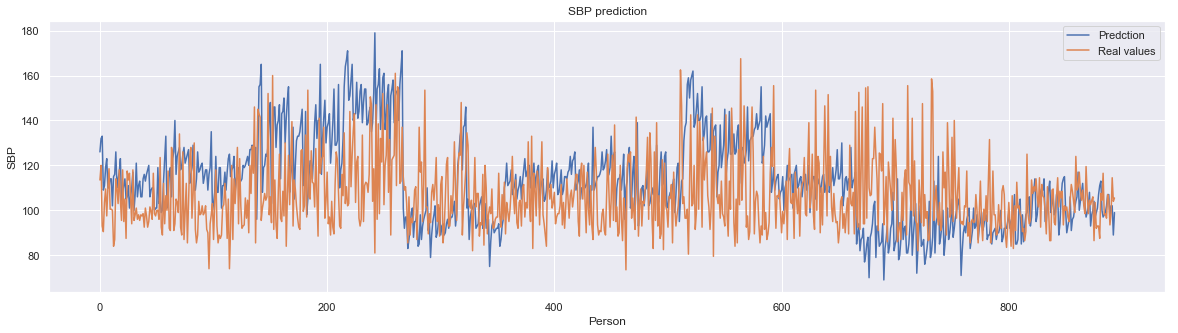

In [352]:
plt.figure(figsize=(20,5))
plt.plot(Y_train1.values)
plt.plot(predict)
plt.title('SBP prediction')
plt.ylabel('SBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

The error here is high. Now let's check the same approuch with filtered data.

# Machine learning with filtered data

In [291]:
#Let's upload data with filtered data
X_train1_filt,X_train2_filt,Y_train1_filt,Y_train2_filt,ID_train_filt = read_data_filtered('data_train')


C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [292]:
#concatenate DataFrames
X_train_filt = pd.concat([X_train1_filt,X_train2_filt],axis=1)

In [371]:
#SBP prediction
kfold = StratifiedKFold(n_splits=5)
KN = KNeighborsRegressor(n_neighbors = 2)
cv = kfold.split(X_train_filt, Y_train1_filt)
scores1 = cross_val_score(KN, X_train_filt, Y_train1_filt, scoring='neg_mean_squared_error', cv=cv)
cv = kfold.split(X_train_filt, Y_train1_filt)
scores2 = cross_val_score(KN, X_train_filt, Y_train1_filt, scoring='neg_mean_absolute_error', cv=cv)
cv = kfold.split(X_train_filt, Y_train1_filt)
scores3 = cross_val_score(KN, X_train_filt, Y_train1_filt, scoring='explained_variance', cv=cv)
cv = kfold.split(X_train_filt, Y_train1_filt)
scores4 = cross_val_score(KN, X_train_filt, Y_train1_filt, scoring='r2', cv=cv)
cv = kfold.split(X_train_filt, Y_train1_filt)
predict = cross_val_predict(KN, X_train_filt, Y_train1_filt, cv=cv)
print('Neg_mean_squared_error metric:  {}'.format(np.mean(scores1)))
print('Neg_mean_absolute_error metric:  {}'.format(np.mean(scores2)))
print('Explained_variance metric:  {}'.format(np.mean(scores3)))
print('R2 metric:  {}'.format(np.mean(scores4)))

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

Neg_mean_squared_error metric:  -427.7877989971672
Neg_mean_absolute_error metric:  -16.19470067682469
Explained_variance metric:  -0.22487438041010357
R2 metric:  -0.22487438041010357


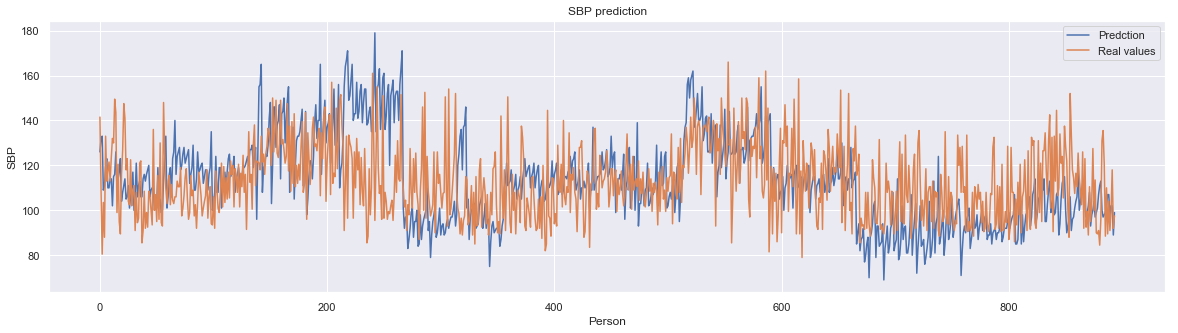

In [355]:
plt.figure(figsize=(20,5))
plt.plot(Y_train1_filt.values)
plt.plot(predict)
plt.title('SBP prediction')
plt.ylabel('SBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

Now the result is a bit better, but still need some improvements

# Machine learning with FFT transform

In [295]:
#Let's upload data with FFT transform
X_train1_fft,X_train2_fft,Y_train1_ftt,Y_train2_ftt,ID_train_ftt = read_data_fft('data_train')

C:\Users\maxel\Anaconda33\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [299]:
#concatenate DataFrames
X_train_fft = pd.concat([X_train1_fft,X_train2_fft],axis=1)



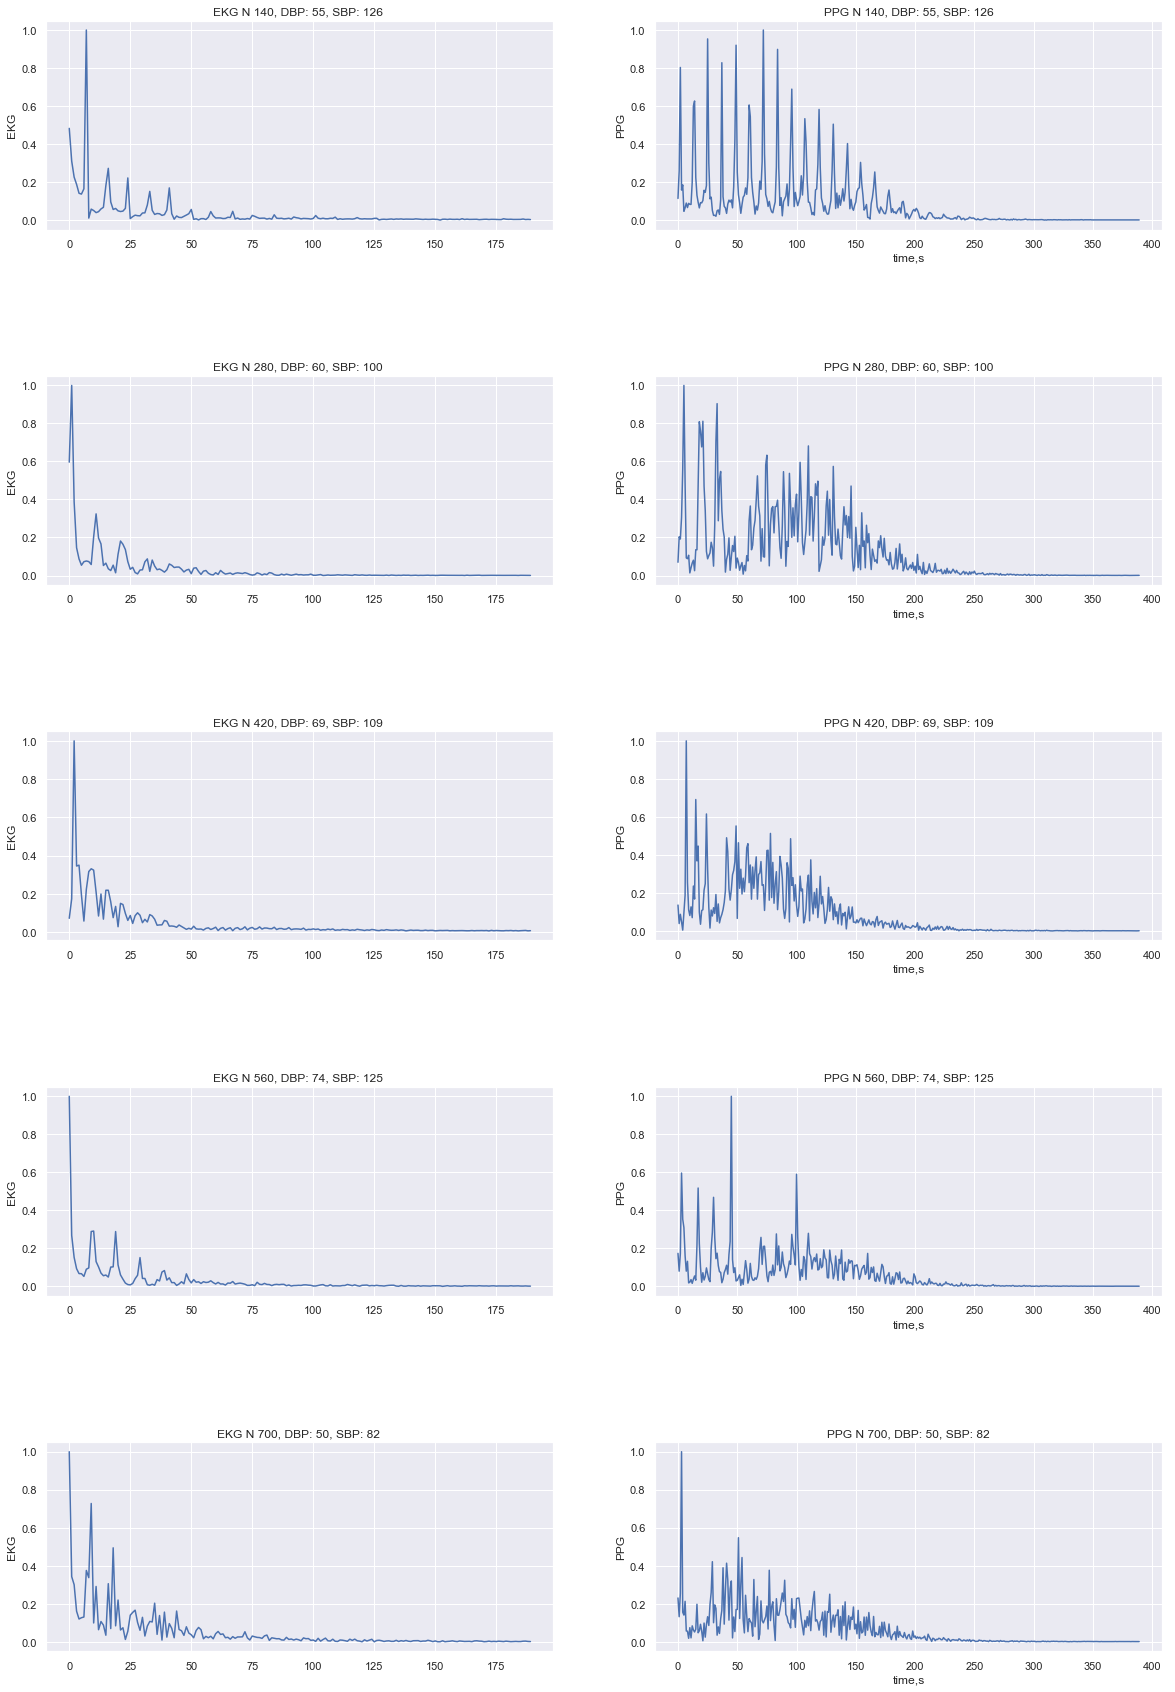

In [323]:
#Plotting of FFT
plt.figure(figsize=(20,30))
m=5
step=140
for i in range(1,m+1):
    
    plt.subplot(m, 2, 2*i-1)
    plt.plot(X_train1_fft.iloc[i*step,:])

    plt.ylabel('EKG')
    plt.title('EKG N %d, DBP: %d, SBP: %d '%(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
#     plt.xticks([])
    plt.subplot(m, 2, 2*i)
    plt.plot(X_train2_fft.iloc[i*step,:])
    plt.xlabel('time,s')
    plt.ylabel('PPG')
    plt.title('PPG N %d, DBP: %d, SBP: %d' %(i*step, matrix[i*step,-1], matrix[i*step,-2] ))
    
plt.subplots_adjust(hspace = 0.7)
plt.show()


In [370]:
#SBP prediction
kfold = StratifiedKFold(n_splits=5)
KN = KNeighborsRegressor(n_neighbors = 2)
cv = kfold.split(X_train_fft, Y_train1_ftt)
scores1 = cross_val_score(KN, X_train_fft, Y_train1_ftt, scoring='neg_mean_squared_error', cv=cv)
cv = kfold.split(X_train_fft, Y_train1_ftt)
scores2 = cross_val_score(KN, X_train_fft, Y_train1_ftt, scoring='neg_mean_absolute_error', cv=cv)
cv = kfold.split(X_train_fft, Y_train1_ftt)
scores3 = cross_val_score(KN, X_train_fft, Y_train1_ftt, scoring='explained_variance', cv=cv)
cv = kfold.split(X_train_fft, Y_train1_ftt)
scores4 = cross_val_score(KN, X_train_fft, Y_train1_ftt, scoring='r2', cv=cv)
cv = kfold.split(X_train_fft, Y_train1_ftt)
predict = cross_val_predict(KN, X_train_fft, Y_train1_ftt, cv=cv)
print('Neg_mean_squared_error metric:  {}'.format(np.mean(scores1)))
print('Neg_mean_absolute_error metric:  {}'.format(np.mean(scores2)))
print('Explained_variance metric:  {}'.format(np.mean(scores3)))
print('R2 metric:  {}'.format(np.mean(scores4)))

C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\maxel\Anaconda33\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. Th

Neg_mean_squared_error metric:  -219.0871165468174
Neg_mean_absolute_error metric:  -11.516910888849015
Explained_variance metric:  0.3401077412391006
R2 metric:  0.3370204486174203


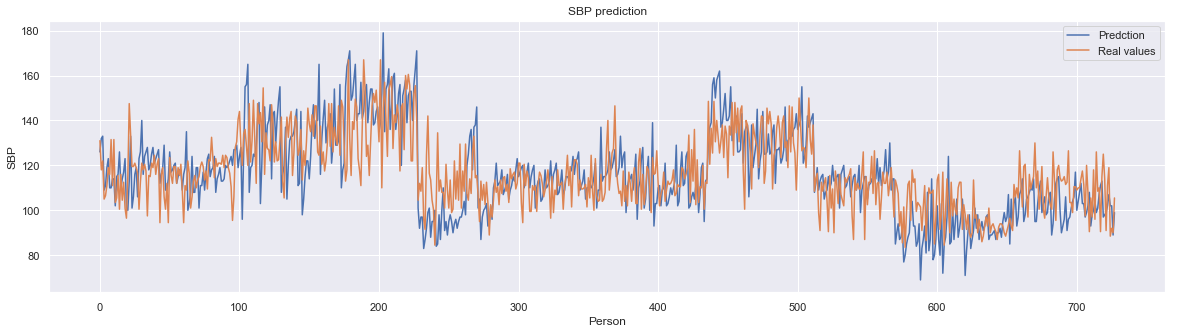

In [358]:
plt.figure(figsize=(20,5))
plt.plot(Y_train1_ftt.values)
plt.plot(predict)
plt.title('SBP prediction')
plt.ylabel('SBP')
plt.xlabel('Person')
plt.legend(['Predction', 'Real values'])

In [ ]:
Here the result is better. It means, that for feature research it is better to work with Fourieк transform analisis.

# Conclusion

Unfortunaty, we didn't get a high score of our prediction. First of all, the imput signals were very noisy that requared to apply filters clean time series signals. Secondly, it's not obvious to extract important features of ECG and PPG that correlated to values of SBP and DBP. We found some articles where this feature were dicribed, but, unfortunatly, it didn't help us a lot. The reason for that could be bad filtering of wrong input data and bad filtering of noised signals. We didn't use here features of FFT analisis. It could improve our results. Probably, the best solution here is an implementation of neural network, that could have two imputs of or signals and predict two output values with corelation to each other. 